In [1]:
import tensorflow as tf
print("tensorflow version: %s" % tf.__version__)
import edward as ed
print("edward version: %s" % ed.__version__)
import edward.models as edm
import edward.inferences as edi

tensorflow version: 1.4.1
edward version: 1.3.4


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Probabilistic Programming
Probabilistic programming involves constructing generative models of data and using inference to determine the parameters of these models.
Simple 'hello world' example: assume our data is noisy measurement of a constant value.  How can we infer the value and the uncertainty?

In [3]:
# Generative model
mu_x = 10.0
sigma_x = 2.0
x_s = edm.Normal(mu_x, sigma_x)

In [4]:
# Sample data produced by model
n_samples = 100
samples = np.zeros(n_samples)
with tf.Session() as sess:
    for i in range(n_samples):
        samples[i] = sess.run(x_s)

In [5]:
# Descriptive statistics
print('Mean: {}'.format(np.mean(samples)))
print('StDev: {}'.format(np.std(samples)))

Mean: 9.52976467609
StDev: 1.97622661613


In [6]:
# Tear down model and work off observations only
tf.reset_default_graph()

In [5]:
# Model for data
N = 100

theta_mu = tf.Variable(0.0)
theta_sigma = tf.Variable(1.0)
x = edm.Normal(loc=tf.ones(N)*theta_mu, scale=tf.ones(N)*theta_sigma)

x_train = samples[:N]

In [18]:
# Descriptive statistics for observed data
print('Mean: {}'.format(np.mean(x_train)))
print('StDev: {}'.format(np.std(x_train)))

Mean: 9.52976467609
StDev: 1.97622661613


Point estimate of model parameters

In [19]:
mle = edi.MAP({}, {x: x_train})

In [20]:
mle.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 212.009


In [21]:
sess = ed.get_session()
sess.run([theta_mu, theta_sigma])

[9.528862, 2.2907968]

Posterior estimate of model parameters

In [37]:
tf.reset_default_graph()

In [88]:
theta_mu_d = edm.Normal(0.0, 1.0)
theta_sigma_d = edm.InverseGamma(0.01, 0.01)
x_d = edm.Normal(loc=tf.ones(N)*theta_mu_d, scale=tf.ones(N)*theta_sigma_d)

In [89]:
q_mu = edm.Normal(tf.Variable(0.0), 1.0)
q_sigma =  edm.InverseGamma(tf.nn.softplus(tf.Variable(0.01)), tf.nn.softplus(tf.Variable(0.01)))

In [90]:
infer = edi.KLqp({theta_mu_d: q_mu, theta_sigma_d: q_sigma}, {x_d: x_train})

In [91]:
infer.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 1559.901


In [92]:
sess = ed.get_session()
sess.run([q_mu, q_sigma])

[0.6110521, 36002792.0]

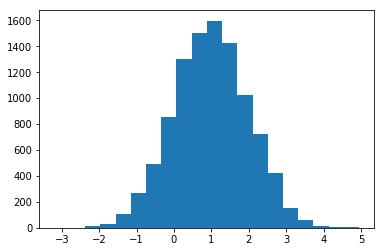

In [93]:
_ = plt.hist([sess.run(q_mu) for _ in range(10000)], bins=20)

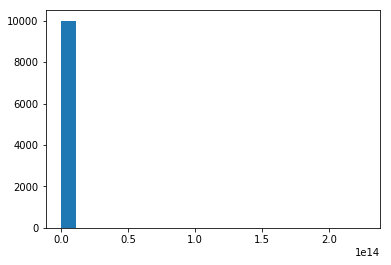

In [94]:
_ = plt.hist([sess.run(q_sigma) for _ in range(10000)], bins=20)